# CD Projekt SA Stock Price Analysis and Forecasting

## Introduction

This project aims to analyze historical stock price data of CD Projekt SA (CDR) and build and compare forecasting models to predict future closing prices. Various modeling techniques, including Linear Regression, XGBoost, LSTM, and Temporal Fusion Transformer (TFT), will be used to evaluate their effectiveness in stock price forecasting.

## Project Goal

The main goals of the project are:
1. Conduct exploratory data analysis of historical CDR stock price data.
2. Feature engineering to create predictive variables.
3. Build and train forecasting models.
4. Evaluate model performance using appropriate metrics.
5. Compare model results and choose the best approach.

## Data

The data used in the project comes from the `CDR.csv` file and contains historical CD Projekt SA stock quotes, including date, closing price, opening price, high, low, and trading volume.

Data source: investing.com (daily OHLCV), period 2020–2024.

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping as PL_EarlyStopping
import torch
import tensorflow as tf
import os
import random
import warnings
warnings.filterwarnings('ignore')


SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [127]:
# PARAMETERS
CSV_PATH = "CDR.csv"
STOCK = "CD Projekt SA"
H = 5
LOOKBACK = 5
ENC_LEN = 5
PRED_LEN = 1
SEED = 0

# repeatability of results
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

## Data Preparation and Feature Engineering

In this section, the data is loaded, cleaned, and prepared for modeling. Data type conversion, sorting by date, and removal of missing values are performed.

Next, feature engineering is conducted, which involves creating new variables based on existing data. This includes lagged prices and volumes, moving averages, technical indicators (MACD, Bollinger Bands, ATR, OBV, CMF), and temporal features (month, seasonality).

## Data Splitting

The data is split into training, validation, and testing sets for model training, hyperparameter tuning, and final performance evaluation on unseen data. The split is done chronologically.

In [128]:
# DATA
raw = pd.read_csv(CSV_PATH, decimal=",")
raw.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change%'][:raw.shape[1]]
raw['Date'] = pd.to_datetime(raw['Date'], format='%d.%m.%Y', errors='coerce')
raw = raw.sort_values('Date').set_index('Date')
for col in ['Close', 'Open', 'High', 'Low', 'Volume']:
    raw[col] = (raw[col].astype(str)
                         .str.replace(r'[^\d,\.]', '', regex=True)
                         .str.replace(',', '.')
                         .replace('', np.nan)
                         .astype(float))
raw = raw.drop(columns=['Change%'], errors='ignore').dropna()

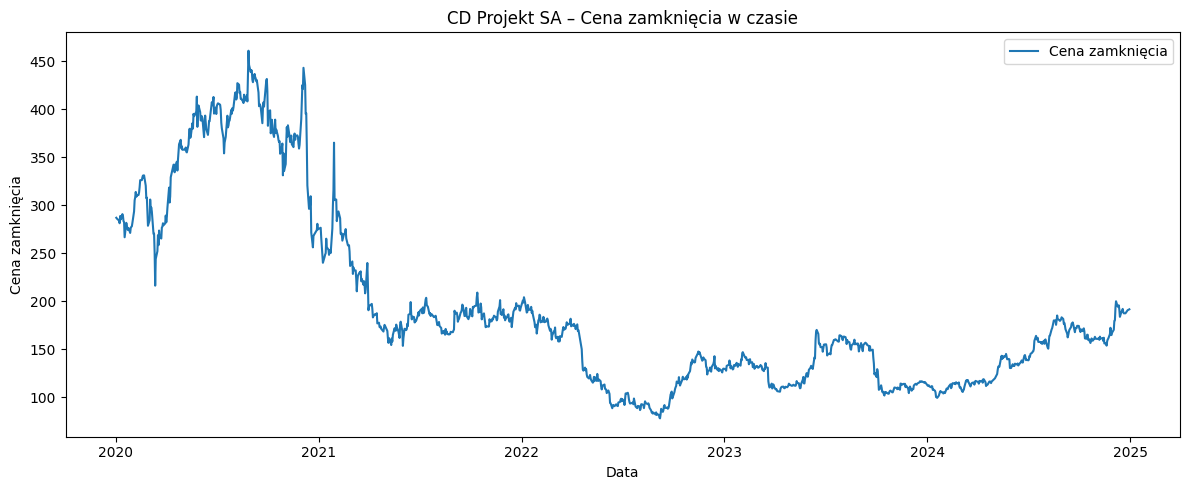

In [129]:
plt.figure(figsize=(12, 5))
plt.plot(raw.index, raw['Close'], label='Cena zamknięcia')
plt.title(f'{STOCK} – Cena zamknięcia w czasie')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia')
plt.legend()
plt.tight_layout()
plt.show()

In [130]:
raw.describe()

,Close,Open,High,Low,Volume
count,1253.000000,1253.000000,1253.000000,1253.000000,1.253000e+03
mean,192.029800,192.278204,196.066872,188.246967,4.839592e+05
std,93.602818,93.622934,95.628509,91.679697,4.785782e+05
min,77.890000,81.000000,82.390000,76.810000,2.008000e+04
25%,121.200000,121.600000,125.300000,118.820000,2.505700e+05
50%,164.400000,164.600000,167.250000,160.500000,3.641500e+05
75%,208.100000,208.800000,212.000000,201.300000,5.487100e+05
max,460.800000,455.300000,464.200000,443.800000,6.860000e+06


In [131]:
# FEATURE ENGINEERING
for l in range(1, 11):
    raw[f'Close_lag{l}']   = raw['Close'].shift(l)
    raw[f'Volume_lag{l}']  = raw['Volume'].shift(l)
raw['MA10']  = raw['Close'].rolling(10).mean()
raw['MA20']  = raw['Close'].rolling(20).mean()
raw['STD20'] = raw['Close'].rolling(20).std()
raw['range'] = raw['High'] - raw['Low']
raw['vol_ma2'] = raw['Volume'].rolling(2).mean()
raw['vol_spike'] = raw['Volume'] / raw['vol_ma2']
raw['volume_per_range'] = raw['Volume'] / (raw['range'] + 1e-6)
raw['MACD'] = raw['Close'].ewm(span=12).mean() - raw['Close'].ewm(span=26).mean()
raw['vol_change'] = raw['Volume'].pct_change()
raw['vol_rolling_mean5'] = raw['Volume'].rolling(5).mean()
raw['vol_rolling_std5'] = raw['Volume'].rolling(5).std()
raw['vol_to_mean20'] = raw['Volume'] / (raw['Volume'].rolling(20).mean() + 1e-6)
bb = ta.volatility.BollingerBands(raw['Close'], window=20, window_dev=2)
raw['BB_high'] = bb.bollinger_hband()
raw['BB_low']  = bb.bollinger_lband()
raw['ATR14'] = ta.volatility.AverageTrueRange(raw['High'], raw['Low'], raw['Close'], window=14).average_true_range()
raw['OBV'] = ta.volume.OnBalanceVolumeIndicator(raw['Close'], raw['Volume']).on_balance_volume()
raw['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(raw['High'], raw['Low'], raw['Close'], raw['Volume'], window=20).chaikin_money_flow()
for i in range(1, 6):
    raw[f'ret_lag{i}'] = raw['Close'].pct_change(i)
raw['moy']   = raw.index.month
day_of_year = raw.index.dayofyear
raw['sin_season'] = np.sin(2 * np.pi * day_of_year/365.25)
raw['cos_season'] = np.cos(2 * np.pi * day_of_year/365.25)
def rolling_slope(x):
    y = np.arange(len(x))
    return np.polyfit(y, x, 1)[0]
raw['slope10'] = raw['Close'].rolling(10).apply(rolling_slope, raw=True)
raw['expanding_mean'] = raw['Close'].expanding().mean()
raw['expanding_std']  = raw['Close'].expanding().std()

# TARGET
raw['Close_t_plus_5'] = raw['Close'].shift(-H)
raw['ret_t_plus_5'] = (raw['Close_t_plus_5'] - raw['Close']) / raw['Close']

raw.dropna(inplace=True)

In [132]:
# FEATURES
feat_xgb = [
    'Close_lag7','Close_lag8','Close_lag9','Close_lag10',
    'Volume_lag7',
    'MA10', 'MA20','range','MACD',
    'vol_spike','volume_per_range','vol_change','vol_rolling_mean5'
]
feat_lstm = [
    'expanding_std', 'expanding_mean', 'CMF', 'OBV', 'ATR14', 'BB_low', 'BB_high',
    'MACD', 'ret_lag4', 'volume_per_range', 'STD20', 'MA10', 'moy', 'sin_season',
    'Close_lag10', 'Close_lag8', 'cos_season', 'slope10', 'ret_lag5', 'vol_rolling_std5'
]
feat_tft = [
    'expanding_std', 'expanding_mean', 'CMF', 'OBV', 'ATR14', 'BB_low', 'BB_high',
    'MACD', 'ret_lag4', 'volume_per_range', 'STD20', 'MA10', 'moy', 'sin_season',
    'Close_lag10', 'Close_lag8', 'cos_season', 'slope10', 'ret_lag5', 'vol_rolling_std5'
]

X_xgb = raw[feat_xgb ].values
X_lstm_full = raw[feat_lstm].values
X_tft = raw[feat_tft ].values
y = raw['ret_t_plus_5'].values

In [133]:
# TRAIN / VAL / TEST split
n = len(raw)
idx_train = int(0.70 * n)
idx_val = int(0.85 * n)

def split(a):
    return a[:idx_train], a[idx_train:idx_val], a[idx_val:]

X_xgb_train, X_xgb_val, X_xgb_test = split(X_xgb)
y_train, y_val, y_test = split(y)

close_test_input = raw['Close'].iloc[idx_val:].values[:len(y_test)]

In [134]:
# LSTM sequences
def make_seq(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X) - H + 1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_lstm_seq, y_lstm_seq = make_seq(X_lstm_full, y, LOOKBACK)

idx_train_lstm = idx_train - LOOKBACK
idx_val_lstm = idx_val - LOOKBACK

X_lstm_train, X_lstm_val, X_lstm_test = (
    X_lstm_seq[:idx_train_lstm],
    X_lstm_seq[idx_train_lstm:idx_val_lstm],
    X_lstm_seq[idx_val_lstm:]
)
y_lstm_train, y_lstm_val, y_lstm_test = (
    y_lstm_seq[:idx_train_lstm],
    y_lstm_seq[idx_train_lstm:idx_val_lstm],
    y_lstm_seq[idx_val_lstm:]
)

idx_lstm = np.arange(idx_val, idx_val + len(X_lstm_test))

close_lstm_test_input = raw['Close'].iloc[idx_lstm].values
true_price_lstm = raw['Close_t_plus_5'].iloc[idx_lstm].values

In [135]:
# SCALING
sc_xgb = StandardScaler().fit(X_xgb_train)
X_xgb_train = sc_xgb.transform(X_xgb_train)
X_xgb_val = sc_xgb.transform(X_xgb_val)
X_xgb_test = sc_xgb.transform(X_xgb_test)

sc_lstm = StandardScaler().fit(X_lstm_train.reshape(-1, X_lstm_train.shape[2]))
def scale_seq(Xseq):
    s = Xseq.shape
    return sc_lstm.transform(Xseq.reshape(-1, s[2])).reshape(s)
X_lstm_train = scale_seq(X_lstm_train)
X_lstm_val = scale_seq(X_lstm_val)
X_lstm_test = scale_seq(X_lstm_test)

## Forecasting Models

The following forecasting models were used in the project:

### Random Walk

A baseline model where the future price is predicted to be equal to the last observed price. It serves as a benchmark for evaluating more complex models.

### Linear Regression

A simple regression model using selected features to predict future stock returns.

### XGBoost (Extreme Gradient Boosting)

An advanced tree-based model known for its high performance in regression and classification tasks.

### LSTM (Long Short-Term Memory)

A type of recurrent neural network (RNN) particularly effective in modeling sequential data, such as time series. In this project, LSTM is used to predict future returns based on a sequence of historical features.

### Temporal Fusion Transformer (TFT)

A model based on the Transformer architecture, specifically designed for time series forecasting. TFT can account for both known future variables and unknown future variables, as well as static and time-varying features.

In [136]:
# MODELS
results = {}

# Random Walk
rw_pred_ret = np.zeros(len(y_test))
rw_pred_price = close_test_input

true_price = raw['Close_t_plus_5'].iloc[idx_val:idx_val + len(y_test)].values

results['RandomWalk'] = (
    mean_squared_error(true_price, rw_pred_price),
    mean_absolute_error(true_price, rw_pred_price)
)

# Linear Regression
lr = LinearRegression().fit(X_xgb_train, y_train)
lr_pred_ret = lr.predict(X_xgb_test)
lr_pred_price = close_test_input * (1 + lr_pred_ret)
results['LinearReg'] = (mean_squared_error(true_price, lr_pred_price),
                        mean_absolute_error(true_price, lr_pred_price))

In [137]:
# XGBoost
eval_set = [(X_xgb_train, y_train), (X_xgb_val, y_val)]
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators = 100,
    max_depth = 3,
    learning_rate = 0.03,
    subsample = 0.85,
    colsample_bytree = 1,
    random_state = SEED,
    verbosity = 0)
xgb_model.fit(
    X_xgb_train, y_train,
    eval_set = eval_set,
    eval_metric = "rmse",
    early_stopping_rounds = 5,
    verbose=False)
xgb_pred_ret = xgb_model.predict(X_xgb_test)
xgb_pred_price = close_test_input * (1 + xgb_pred_ret)
results['XGB'] = (mean_squared_error(true_price, xgb_pred_price),
                  mean_absolute_error(true_price, xgb_pred_price))

In [138]:
importances = xgb_model.feature_importances_
for col, imp in zip(feat_xgb, importances):
    print(f"{col}: {imp:.3f}")

Close_lag7: 0.091
Close_lag8: 0.213
Close_lag9: 0.072
Close_lag10: 0.034
Volume_lag7: 0.037
MA10: 0.067
MA20: 0.103
range: 0.063
MACD: 0.105
vol_spike: 0.049
volume_per_range: 0.060
vol_change: 0.000
vol_rolling_mean5: 0.107


In [139]:
# LSTM
K.clear_session()

n_steps, n_feat = X_lstm_train.shape[1], X_lstm_train.shape[2]
lstm = Sequential([
    LSTM(128, activation='relu',
         return_sequences=True,
         input_shape=(n_steps, n_feat),
         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
         recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.2, seed=SEED),
    LSTM(64, activation='relu',
         return_sequences=True,
         input_shape=(n_steps, n_feat),
         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
         recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.2, seed=SEED),
    LSTM(32, activation='relu',
         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
         recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.2, seed=SEED),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm.compile(optimizer=optimizer, loss='mse')

lstm.fit(
    X_lstm_train, y_lstm_train,
    epochs=100, batch_size=32,
    validation_data=(X_lstm_val, y_lstm_val),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1, shuffle=False
)

lstm_pred_ret = lstm.predict(X_lstm_test, verbose=0).flatten()
lstm_pred_price = close_lstm_test_input * (1 + lstm_pred_ret)

true_price_lstm = raw['Close_t_plus_5'].iloc[idx_lstm].values

results['LSTM'] = (
    mean_squared_error(true_price_lstm, lstm_pred_price),
    mean_absolute_error(true_price_lstm, lstm_pred_price)
)

Epoch 1/100
27/27 [==============================] - 7s 47ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 2/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 4/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 5/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 6/100
27/27 [==============================] - 1s 37ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 7/100
27/27 [==============================] - 1s 32ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 8/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 9/100
27/27 [==============================] - 0s 16ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 10/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0044 - val_loss: 0.0029

In [140]:
# TFT

from pytorch_lightning.loggers import CSVLogger
seed_everything(SEED, workers=True)

data_tft = raw.reset_index(drop=True)
data_tft["stock"] = STOCK
data_tft["time_idx"]= np.arange(len(data_tft))
test_df = data_tft.iloc[idx_val-ENC_LEN:].copy()
train_df = data_tft.iloc[:idx_train].copy()
val_df = data_tft.iloc[idx_train:idx_val].copy()

common_ds_kwargs = dict(
    time_idx ="time_idx",
    target ="ret_t_plus_5",
    group_ids =["stock"],
    max_encoder_length =ENC_LEN,
    max_prediction_length =PRED_LEN,
    static_categoricals =["stock"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=feat_tft + ["ret_t_plus_5"],
    target_normalizer =GroupNormalizer(groups=["stock"])
)

ds_train = TimeSeriesDataSet(train_df, **common_ds_kwargs)
ds_val = TimeSeriesDataSet(val_df, **common_ds_kwargs)
ds_test = TimeSeriesDataSet(test_df, **common_ds_kwargs)

dl_train = ds_train.to_dataloader(train=True, batch_size=128, num_workers=0)
dl_val = ds_val.to_dataloader(train=False, batch_size=128, num_workers=0)
dl_test = ds_test.to_dataloader(train=False, batch_size=128, num_workers=0)

tft = TemporalFusionTransformer.from_dataset(
    ds_train,
    hidden_size=128,
    hidden_continuous_size=64,
    attention_head_size=1,
    dropout=0.1,
    learning_rate=1e-4,
    loss=RMSE()
)

trainer = Trainer(
    max_epochs=100,
    accelerator="cpu",
    logger=False,
    callbacks=[PL_EarlyStopping(monitor="val_loss", patience=8, min_delta=1e-4)]
)
trainer.fit(tft, dl_train, dl_val)

pred_raw = tft.predict(dl_test, mode="raw")
tft_pred_ret = pred_raw["prediction"][:, 0, 0].cpu().numpy()

close_test_input = raw["Close"].iloc[idx_val: idx_val+len(tft_pred_ret)].values
tft_pred_price = close_test_input * (1 + tft_pred_ret)
true_price_tft = raw["Close_t_plus_5"].iloc[idx_val: idx_val+len(tft_pred_ret)].values

results["TFT"] = (mean_squared_error(true_price_tft, tft_pred_price),
                    mean_absolute_error(true_price_tft, tft_pred_price))


Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 2.8 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 384    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 601 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 25.7 K | train
7  | static_context_variable_selection  | GatedRe

Epoch 42: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s, train_loss_step=0.0368, val_loss=0.0311, train_loss_epoch=0.0412]


Missing logger folder: c:\Users\wboks\Downloads\Forecast\lightning_logs


## Results Visualization

Visualizations show a comparison of actual closing prices with forecasts from individual models on the test set. This allows for a visual assessment of forecast accuracy and identification of potential deviations.

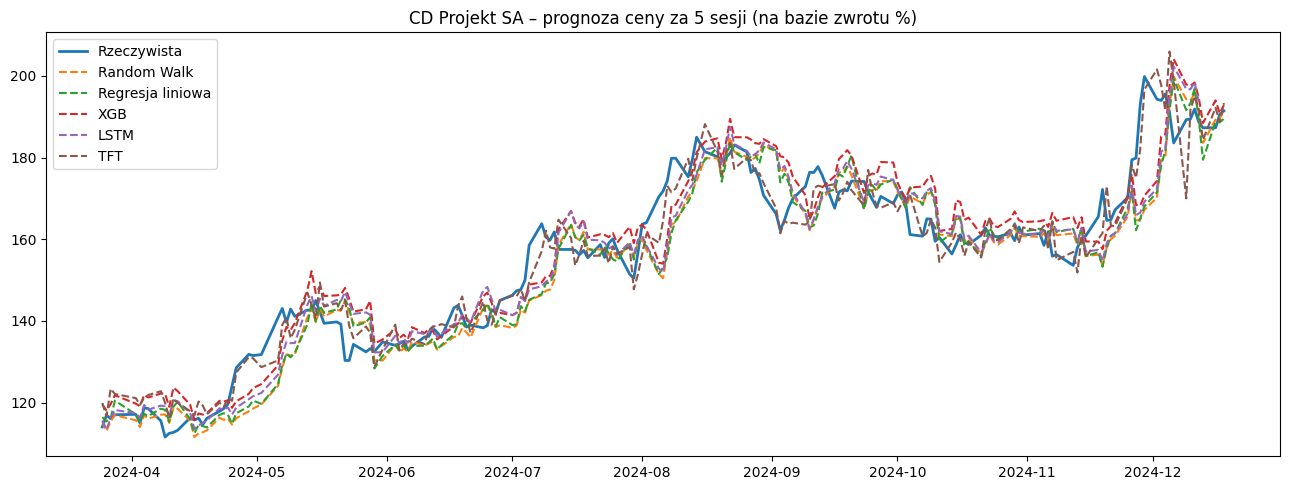

In [141]:
# CHART
idx_test = raw.index[idx_val:idx_val + len(true_price)]
idx_tft = raw.index[idx_val:idx_val+len(tft_pred_price)]
idx_lstm_id = raw.index[idx_lstm]

plt.figure(figsize=(13,5))
plt.plot(idx_test, true_price, label="Rzeczywista", lw=2)

plt.plot(idx_test, rw_pred_price, "--", label="Random Walk")
plt.plot(idx_test, lr_pred_price, "--", label="Regresja liniowa")
plt.plot(idx_test, xgb_pred_price, "--", label="XGB")

plt.plot(idx_lstm_id, lstm_pred_price, "--", label="LSTM")
plt.plot(idx_tft, tft_pred_price, "--", label="TFT")

plt.title(f"{STOCK} – prognoza ceny za {H} sesji (na bazie zwrotu %)")
plt.legend()
plt.tight_layout()
plt.show()

## Model Evaluation

Model performance is evaluated using the following metrics:

*   **RMSE (Root Mean Squared Error)**: The square root of the mean squared error, measures the typical magnitude of forecast errors.
*   **MAE (Mean Absolute Error)**: The mean absolute error, measures the average magnitude of forecast errors without considering their direction.
*   **MAPE (Mean Absolute Percentage Error)**: The mean absolute percentage error, measures the forecast error as a percentage of the actual value.
*   **Hit% (Hit Rate)**: The percentage of correctly predicted price change directions (increase/decrease).
*   **R2 (R-squared)**: The coefficient of determination, indicates what proportion of the variance in the dependent variable is explained by the model.

The metric results for each model are presented in a table, allowing for comparison of their performance.

In [142]:
# METRYKI
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

def hit_rate(y_true_ret, y_pred_ret):
    return np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

pred_price = {
    "RandomWalk": rw_pred_price,
    "LinReg": lr_pred_price,
    "XGB": xgb_pred_price,
    "LSTM": lstm_pred_price,
    "TFT": tft_pred_price,
}
pred_ret = {
    "RandomWalk": rw_pred_ret,
    "LinReg": lr_pred_ret,
    "XGB": xgb_pred_ret,
    "LSTM": lstm_pred_ret,
    "TFT": tft_pred_ret,
}

metrics = []

def add(name, y_true_p, y_pred_p, y_true_r, y_pred_r):
    metrics.append({
        "Model": name,
        "RMSE": rmse(y_true_p, y_pred_p),
        "MAE": mean_absolute_error(y_true_p, y_pred_p),
        "MAPE": mape(y_true_p, y_pred_p),
        "Hit%": hit_rate(y_true_r, y_pred_r)*100,
        "R2": r2_score(y_true_p, y_pred_p)
    })

add("RandomWalk", true_price, rw_pred_price, y_test, rw_pred_ret)
add("LinReg", true_price, lr_pred_price, y_test, lr_pred_ret)
add("XGB", true_price, xgb_pred_price, y_test, xgb_pred_ret)
add("LSTM", true_price_lstm, lstm_pred_price,
        y_lstm_test, lstm_pred_ret)
add("TFT", true_price_tft, tft_pred_price,
        y[idx_val:idx_val+len(tft_pred_ret)], tft_pred_ret)

print(pd.DataFrame(metrics).set_index("Model").round(4))

              RMSE     MAE    MAPE     Hit%      R2
Model                                              
RandomWalk  8.1098  5.9035  3.7367   0.0000  0.8609
LinReg      8.0087  5.8522  3.6921  59.4595  0.8643
XGB         7.9994  6.2863  4.0138  58.3784  0.8646
LSTM        7.8432  5.8154  3.6656  58.5635  0.8655
TFT         4.9880  3.8312  2.4879  78.3784  0.9474


## Summary and Conclusions

This analysis evaluated several models for forecasting CD Projekt SA (CDR) stock prices over a test period characterized by a strong upward trend and significant volatility.

*   **Linear Regression:** Followed the long-term trend but smoothed out dynamic movements, struggling to keep pace with rapid changes, particularly during sharp increases.
*   **XGBoost:** Showed more reactivity to changes and better captured rapid increases compared to linear regression, although with some slight overestimations at times.
*   **LSTM:** Demonstrated high prediction stability, closely following the actual price for most of the period and accurately reflecting periods of stabilization and gradual growth.
*   **TFT:** Proved most precise in tracking both sudden upward movements and corrections. Its predictions closely matched the actual price in both direction and scale, especially during periods of dynamic acceleration at the end of the year.

Based on the evaluation metrics and visualizations, the **Temporal Fusion Transformer (TFT)** model achieved the best performance, accurately capturing the complex dynamics of CDR stock prices. Linear Regression showed a slight improvement over the Random Walk baseline.

Future work could involve hyperparameter tuning for all models, exploring additional features, and testing on different time periods or stocks.